In [1]:
import os

import numpy as np
import awkward as ak
import coffea.processor as processor
from coffea.nanoevents import schemas
import hist

In [2]:
fileset = {
    'ZZ' : [
        'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/010B000A-0883-064B-B250-A6159DB2603A.root',
    ],
}

In [3]:
class Processor(processor.ProcessorABC):
    def process(self, events):
        dataset = events.metadata["dataset"]
        
        self.dataset_axis = hist.axis.StrCategory(name="dataset", label="", categories=[], growth=True)
        self.bins = {}
        
        self.bins['e_pT'] = hist.axis.Regular(name="e_pT", label="electron $p_{T}$ [GeV]", bins = 20, start=0, stop=200)
        
        output = {}
        for h in self.bins:
            output[h] = hist.Hist(self.dataset_axis, self.bins[h], label="Events")
        
        electrons = events.Electron
        
        electrons = electrons[
            (np.abs(electrons.eta) < 2.5) &
            (electrons.lostHits == 0) &
            (electrons.convVeto) &
            (electrons.tightCharge > 0) &
            (electrons.pt > 10)
        ]
        
        output['e_pT'].fill(dataset=dataset, e_pT=ak.flatten(electrons.pt))
        
        return output

    def postprocess(self, accumulator):
        pass
        

In [4]:
from dask.distributed import Client
client = Client("tls://localhost:8786")

In [5]:
import time

# This function ensures that we aren't overwriting Dask report filenames.
def unique(filename):
    file, ext = os.path.splitext(filename)
    counter = 0
    while os.path.exists(filename):
        counter += 1
        filename = file + str(counter) + ext
    return filename

tic = time.time()

from dask.distributed import performance_report
fname = unique("dask-report-" + "AUTO" + str(int(len(fileset)/18)) + "F" + ".html")
with performance_report(filename=fname):
    executor = processor.DaskExecutor(client=client)
    run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )
    output, metrics = run(fileset, "Events", processor_instance=Processor())
    
toc = time.time()

print("Total time: %.0f" % (toc - tic))
print("Events / s / thread: {:,.0f}".format(metrics['entries'] / metrics['processtime']))
print("Events / s: {:,.0f}".format(metrics['entries'] / (toc - tic)))

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


Total time: 41###########################] | 100% Completed |  3.6s
Events / s / thread: 70,553
Events / s: 936


In [6]:
import matplotlib.pyplot as plt

def plot_hists(output):
    for histo in output:
        fig, ax = plt.subplots(1)
        output[histo].plot1d()
        ax.legend()

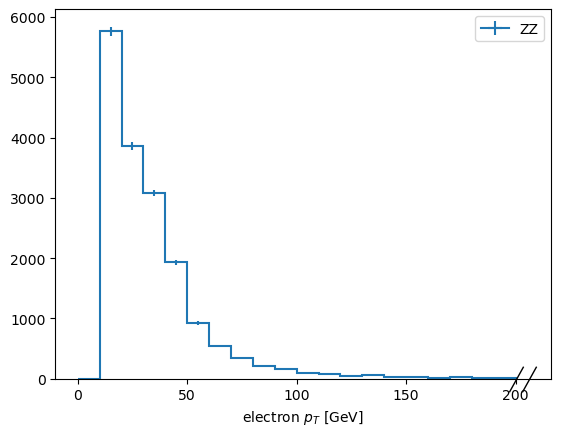

In [7]:
plot_hists(output)